# Evaluate on Test Data

## Setup

In [1]:
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

from hot_dust import preprocess, model

In [29]:
# "reload" to get changes in preprocess.py without restarting the kernel
reload(preprocess)
reload(model)
from hot_dust.preprocess import prepare_training_data, split_training_data, sensitivity_analysis
from hot_dust.model import to_tensorflow

In [3]:
ds = prepare_training_data()
train, validate, test = to_tensorflow(split_training_data(ds))
batch_size = test.cardinality()
test = test.batch(batch_size)   
ds

<xarray.Dataset>
Dimensions:   (sample: 250000, features: 8, output_dim: 2)
Coordinates:
  * features  (features) <U20 'viewing_zenith_angle' 'spress' ... 'bt_12000'
Dimensions without coordinates: sample, output_dim
Data variables:
    x         (sample, features) float32 64.0 1.013e+03 68.42 ... 250.2 250.0
    y         (sample, output_dim) float32 -1.826 291.8 -0.4952 ... 0.3864 271.6
    split     (sample) <U8 'train' 'train' 'train' ... 'train' 'train' 'train'
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

## Model Summary

In [4]:
network = tf.keras.models.load_model("data/network", compile=False)
network.summary() 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 467
Trainable params: 450
Non-trainable params: 17
______________________________________________________________

## Metrics

In [5]:
# Calculate metrics (.eg MSE, R2) on test data and tabulate 

# Calculate R2 
def get_R2(y_true, y_pred): 
    y_mean = np.mean(y_true)  # mean of the true values
    SS_total = np.sum((y_true - y_mean) ** 2)  # total sum of squares
    SS_reg = np.sum((y_true - y_pred) ** 2)  #  sum of squares due to regression

    R2 = 1 - (SS_reg / SS_total)
    return R2

y = np.concatenate(list(i[1] for i in test.as_numpy_iterator()))  # true values (y_true)
y_hat = network.predict(test, verbose=0)  # predicted values (y_pred)
y_hat_dust= y_hat[:, 0] 
y_hat_temp = y_hat[:, 1]

# Calculate the MSE for the dust and the temperature
MSE_dust = np.square(np.subtract(y[:,0], y_hat_dust)).mean() 
MSE_temp = np.square(np.subtract(y[:,1], y_hat_temp)).mean()

# Calculate the R2 for the dust and the temperature 
R2_dust = get_R2(y[:,0], y_hat_dust)
R2_temp = get_R2(y[:,1], y_hat_temp)

# Return the metrics
print("Metrics: ") 
print(f"Mean Squared Error (Dust): {MSE_dust:.4f}")
print(f"R2 (Dust): {R2_dust:.4f}")
print(f"Mean Squared Error (Temperature): {MSE_temp:.4f}")
print(f"R2 (Temperature): {R2_temp:.4f}")

Metrics: 
Mean Squared Error (Dust): 0.5133
R2 (Dust): 0.4425
Mean Squared Error (Temperature): 15.4824
R2 (Temperature): 0.8176


In [15]:
y[:,0]

array([-1.37375   ,  0.32983604, -0.565881  , ..., -1.11436   ,
       -2.63855   , -0.625554  ], dtype=float32)

## Plots

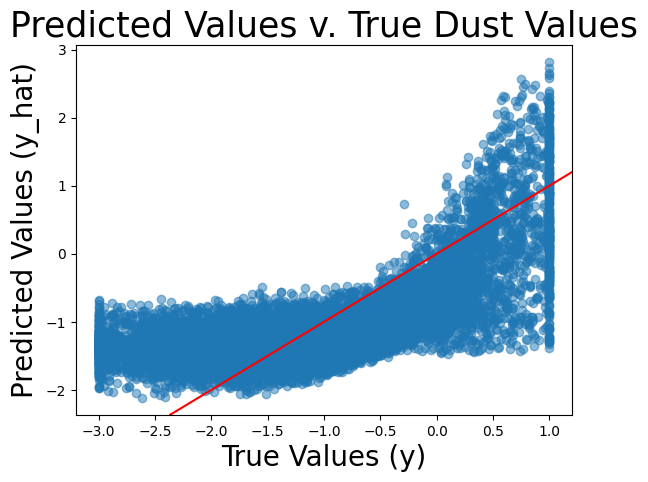

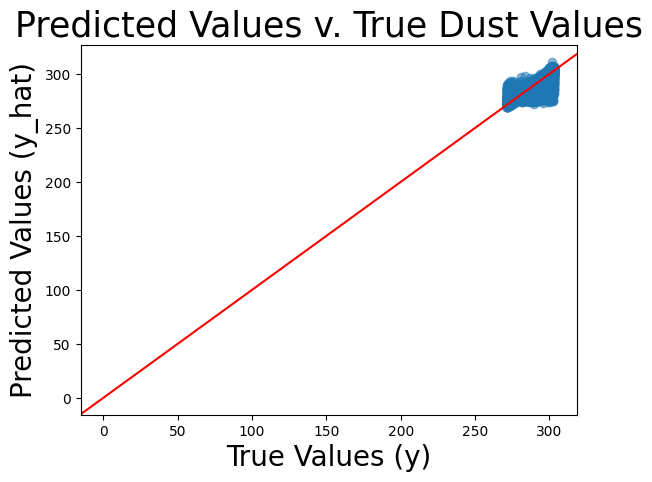

In [13]:
# Plot of y_hat against y, with a one-to-one line overlayed 

# Dust Plot
# plot y_hat against y
plt.scatter(y[:,0], y_hat_dust, alpha=0.5)
# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Predicted Values (y_hat)", fontsize=20)
plt.title("Predicted Values v. True Dust Values", fontsize=25)
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red") 
plt.show()  

# Temperature Plot
# plot y_hat against y
plt.scatter(y[:,1], y_hat_temp, alpha=0.5)
# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Predicted Values (y_hat)", fontsize=20)
plt.title("Predicted Values v. True Temperature Values", fontsize=25)
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red") 
plt.show() 



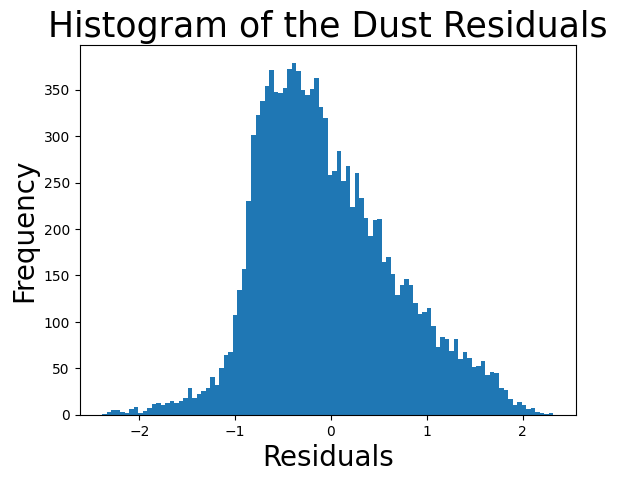

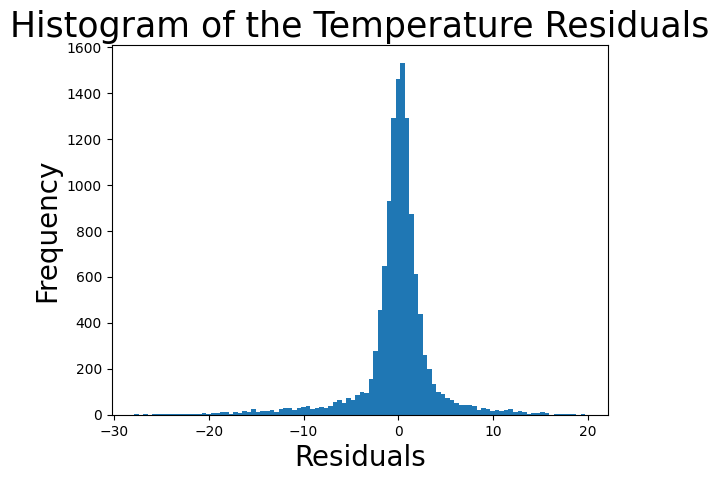

In [16]:
# Plot a histogram of the residuals 

# Plot for Dust
residual_dust = y_hat_dust - y[:,0]
num_bins = 100
plt.hist(residual_dust, num_bins)
plt.title("Histogram of the Dust Residuals", fontsize=25)
plt.xlabel("Residuals", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.show() 

# Plot for Temperature
residual_temp = y_hat_temp - y[:,1]
num_bins = 100
plt.hist(residual_temp, num_bins)
plt.title("Histogram of the Temperature Residuals", fontsize=25)
plt.xlabel("Residuals", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.show()

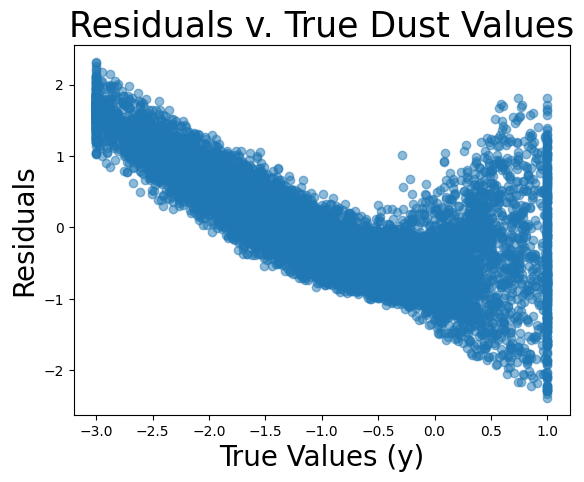

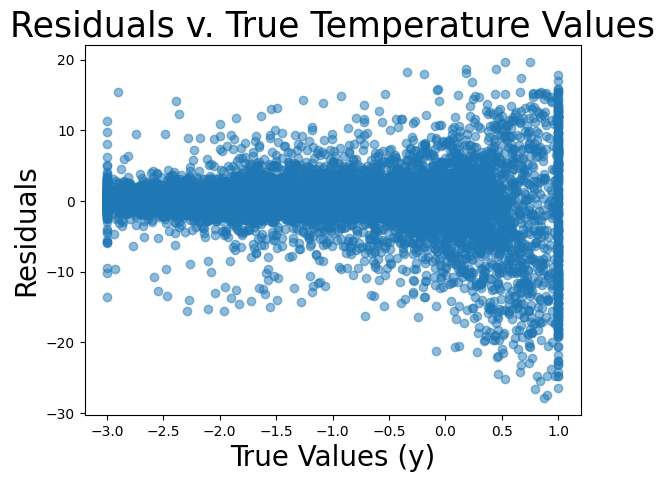

In [18]:
# Plot of the residuals against y 

# Dust Residuals against y
plt.scatter(y[:,0], residual_dust, alpha=0.5)
# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Residuals", fontsize=20)
plt.title("Residuals v. True Dust Values", fontsize=25) 
plt.show()

# Temperature Residuals against y
plt.scatter(y[:,0], residual_temp, alpha=0.5)
# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Residuals", fontsize=20)
plt.title("Residuals v. True Temperature Values", fontsize=25) 
plt.show()

## Heat Maps 

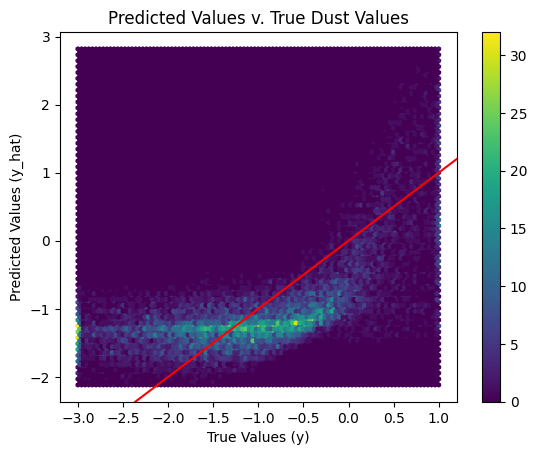

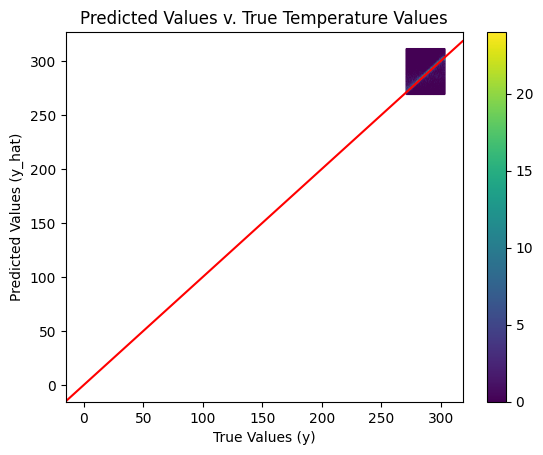

In [20]:
# Heat map of y_hat against y

# Dust Heat Map
# create the heatmap of y_hat against y
plt.hexbin(y[:,0], y_hat_dust, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Dust Values")
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")
plt.colorbar() 
plt.show() 

# Temp Heat Map
# create the heatmap of y_hat against y
plt.hexbin(y[:,1], y_hat_temp, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Temperature Values")
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")
plt.colorbar() 
plt.show()

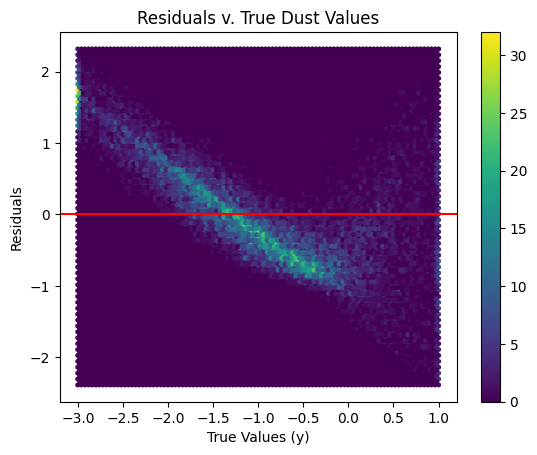

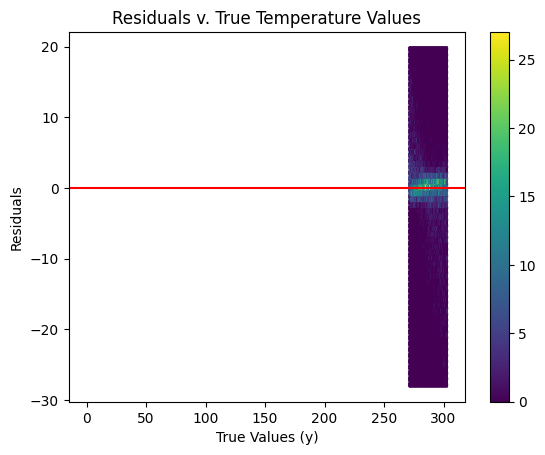

In [21]:
# Heat map of the residuals against y

# Dust Heat Map 
# create the heatmap of residuals against y
plt.hexbin(y[:,0], residual_dust, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Dust Values")
# zero horizontal line overlay
plt.axline([0, 0], slope=0, color="red")
plt.colorbar() 
plt.show() 

# Temperature Heat Map 
# create the heatmap of residuals against y
plt.hexbin(y[:,1], residual_temp, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Temperature Values")
# zero horizontal line overlay
plt.axline([0, 0], slope=0, color="red")
plt.colorbar() 
plt.show()

## Sensitivity Analysis

In [30]:
percentage = 2 # in %; 2%, 5%, 10%
sensitivity_analysis(ds, network, percentage)

7813/7813 [==============================] - 6s 756us/step


ValueError: operands could not be broadcast together with shapes (250000,) (8,) (250000,) 

In [ ]:
# TODO test on a grnaule put on the same plot 